<a target="_blank" href="https://colab.research.google.com/github/evaalonsoortiz/ELE8812-demos/blob/main/Demos/Lesson%208/Le%C3%A7on_8_Demo_AnalysePyramidale.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# ELE8812 - Analyse multirésolution
## Démo : Analyse pyramidale

L’analyse pyramidale permet d’obtenir une représentation multi-résolution d’une image, allant de l’image originale à une représentation à très faible résolution de l’image. Dans ce démo, 2 types de pyramide seront obtenues, une pyramide de Gauss et une pyramide de Laplace.

La pyramide de Gauss est obtenue en appliquant un filtre moyenneur gaussien (*Gaussian blur*) avant d’effectuer un sous-échantillonnage de l’image. Ce processus est répété sur les images sous-échantillonnées jusqu’au niveau final désiré. Les images sous-échantillonnées sont conservées. Dans ce démo, un facteur de sous-échantillonnage de 0.5 est utilisé et 5 niveaux sont obtenus. 

La pyramide de Laplace s’obtient de la même façon que la pyramide de Gauss mais ce sont les différences entre l’image filtrée passe-bas et l’image non-filtrée qui sont conservées à chaque niveau. Pour le dernier niveau, l’image sous-échantillonnée est conservée. Cette approche peut être utilisée pour la compression d’image. Une image de taille identique à l’image originale peut être reconstruite à partir des images de taille réduite.


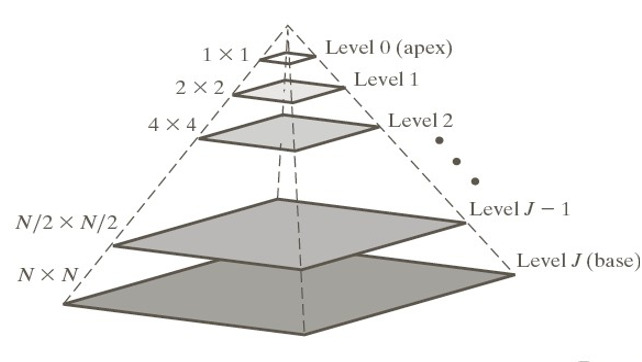

In [55]:
Image("Repo/Data/pyramid.png")

**Source:** 1992-2008 R. C. Gonzalez & R. E. Woods

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata

from skimage.data import astronaut
from IPython.display import Image


# Option d'affichage
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.titlepad'] = 15
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
!git clone https://github.com/evaalonsoortiz/ELE8812-demos.git Repo

Cloning into 'Repo'...
remote: Enumerating objects: 415, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 415 (delta 16), reused 30 (delta 12), pack-reused 362
Receiving objects: 100% (415/415), 48.39 MiB | 10.76 MiB/s, done.
Resolving deltas: 100% (145/145), done.


## Image originale

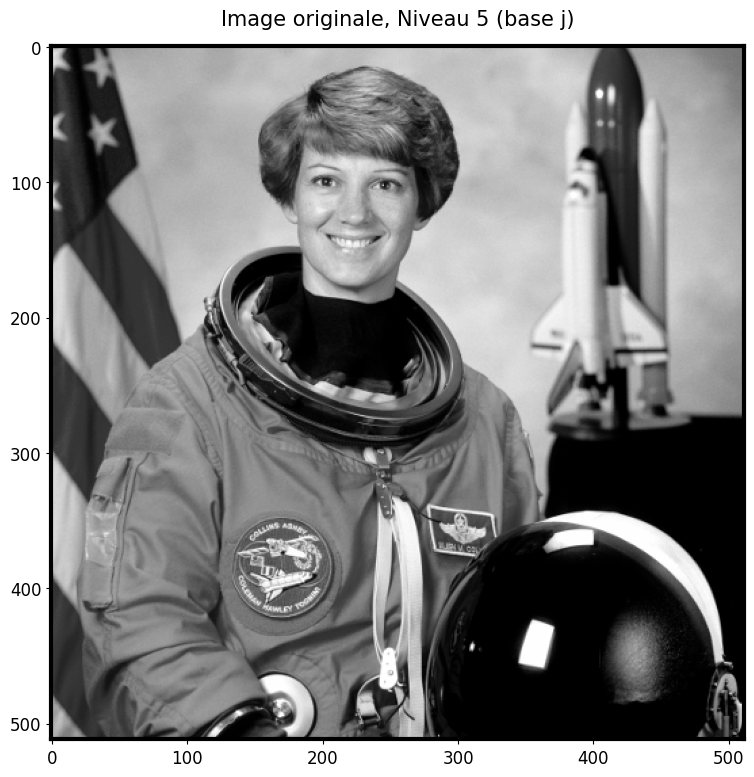

Help on function astronaut in module skimage.data._fetchers:

astronaut()
    Color image of the astronaut Eileen Collins.
    
    Photograph of Eileen Collins, an American astronaut. She was selected
    as an astronaut in 1992 and first piloted the space shuttle STS-63 in
    1995. She retired in 2006 after spending a total of 38 days, 8 hours
    and 10 minutes in outer space.
    
    This image was downloaded from the NASA Great Images database
    <https://flic.kr/p/r9qvLn>`__.
    
    No known copyright restrictions, released into the public domain.
    
    Returns
    -------
    astronaut : (512, 512, 3) uint8 ndarray
        Astronaut image.



In [3]:
image = astronaut().mean(axis=2)
plt.imshow(image);
plt.title('Image originale, Niveau 5 (base j)')
plt.show()
help(astronaut)

## Approximation niveau 4 ($j$ - 1)

Un filtre de moyennage gaussien est appliqué avant que l’image soit sous-échantillonnée par un facteur de 2. L’image passe d’une taille de N x N à une taille de N/2 x N/2.


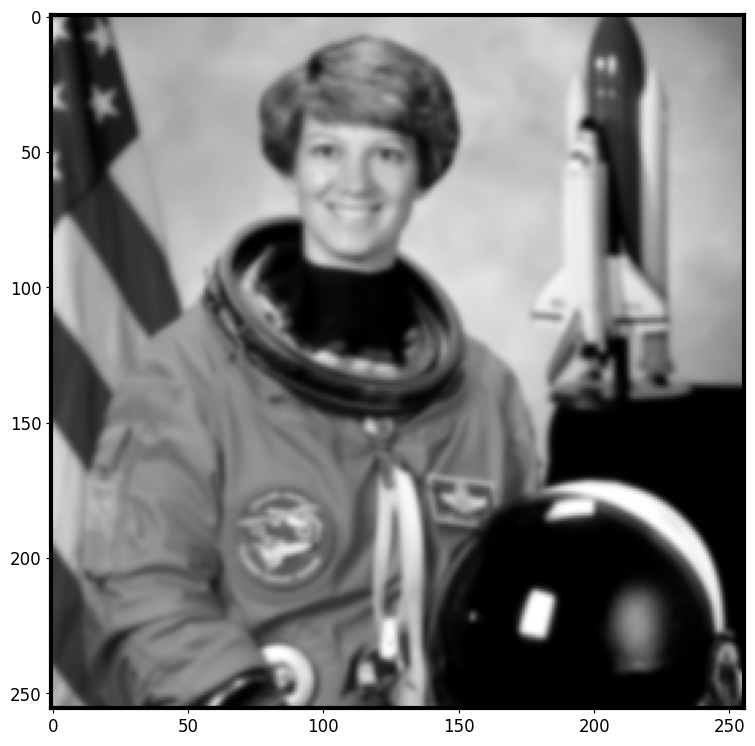

In [4]:
# Approximation (Filtre Gaussien 2D)
img_approx = gaussian_filter(image, sigma=2)

# Sous-échantillonnage d'un facteur 2
img_approx = img_approx[0::2, 0::2]

plt.imshow(img_approx); plt.show()

## Prédiction et résidu du niveau 5 ($j$)

L’image sous-échantillonnée est ensuite sur-échantillonnée pour retourner à la taille originale N x N. L’interpolation bilinéaire est utilisée pour ce faire. L’image reconstruite est plus floue que l’image originale et les contours fins ressortent dans la différence entre les 2 images.




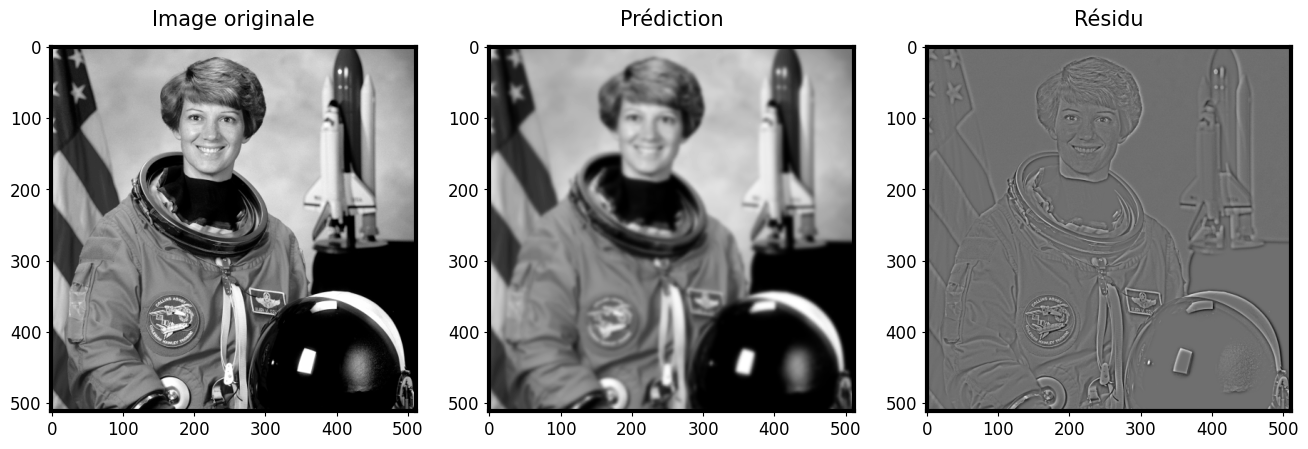

In [5]:
nx, ny = image.shape; nx_a, ny_a = img_approx.shape

x_0, y_0 = np.meshgrid(np.linspace(0,1,nx), np.linspace(0,1,ny))
x_1, y_1 = np.meshgrid(np.linspace(0,1,nx_a), np.linspace(0,1,ny_a))
points = np.array([x_1.ravel(), y_1.ravel()]).T
values = img_approx.ravel()

# Interpolation bi-linéaire
img_prediction = griddata(points, values, (x_0, y_0), method='linear')

# Calcul du résidu pour le niveau j=1
img_residu = image - img_prediction

plt.subplot(131); plt.imshow(image); plt.title('Image originale')
plt.subplot(132); plt.imshow(img_prediction); plt.title(u'Prédiction')
plt.subplot(133); plt.imshow(img_residu); plt.title(u'Résidu')
plt.show()

## Décomposition pyramidale

Répétition de l’algorithme suivant pour chaque niveau j allant de 5 à 1 :
1.	Calcul d’une approximation j-1 de l’image de niveau j
2.	Reconstruction/prédiction de l’image de niveau j à partir de l’image de niveau j-1
3.	Calcul des résidus de la prédiction


Les contours dans l’image des résidus deviennent de plus en plus grossiers plus le niveau pyramidal diminue.


In [6]:
def decomposition_apr(img, k=1):
    # Approximation (Filtre Gaussien 2D)
    img_approx = gaussian_filter(img, k)

    # Sous-échantillonnage d'un facteur 2
    img_approx = img_approx[0::2, 0::2]

    nx, ny = img.shape; nx_a, ny_a = img_approx.shape
    x_0, y_0 = np.meshgrid(np.linspace(0,1,nx), np.linspace(0,1,ny))
    x_1, y_1 = np.meshgrid(np.linspace(0,1,nx_a), np.linspace(0,1,ny_a))
    points = np.array([x_1.ravel(), y_1.ravel()]).T
    values = img_approx.ravel()

    # Interpolation bi-linéaire
    img_prediction = griddata(points, values, (x_0, y_0), method='linear')

    # Calcul du résidu
    img_residu = img - img_prediction

    return img_approx, img_prediction, img_residu

In [7]:
def display_pyramid_iteration(img, img_approx, img_prediction, img_residual, j):
    plt.subplot(141); plt.imshow(img); plt.title('Image originale (Niv. {})'.format(nombre_de_niveaux - j))
    plt.subplot(142); plt.imshow(img_approx); plt.title(u'Image approximée (Niv. {})'.format(nombre_de_niveaux - j -1))
    plt.subplot(143); plt.imshow(img_prediction); plt.title(u'Image prédite (Niv. {})'.format(nombre_de_niveaux - j))
    plt.subplot(144); plt.imshow(img_residu); plt.title(u'Résidu (Niv. {})'.format(nombre_de_niveaux - j))
    plt.show()

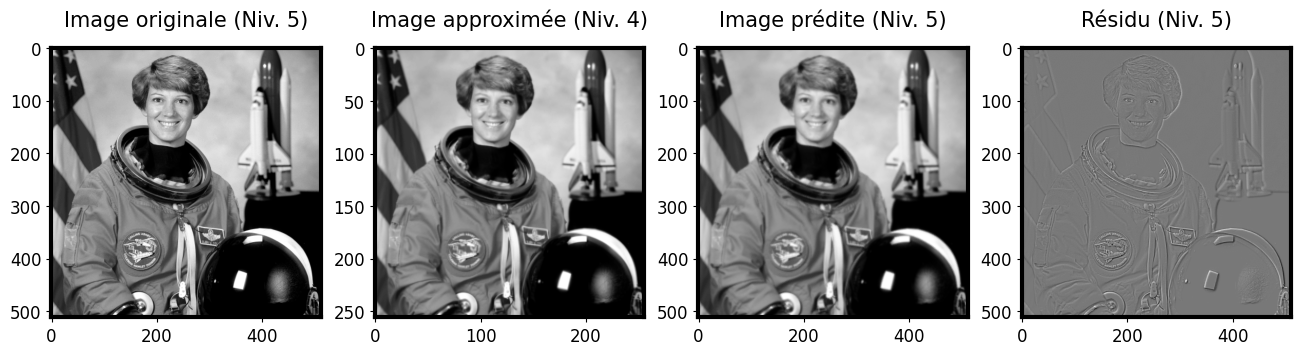

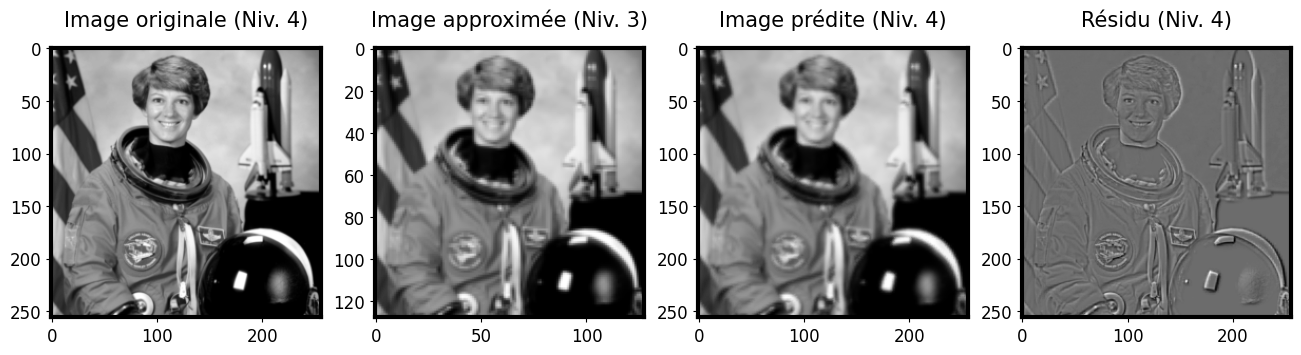

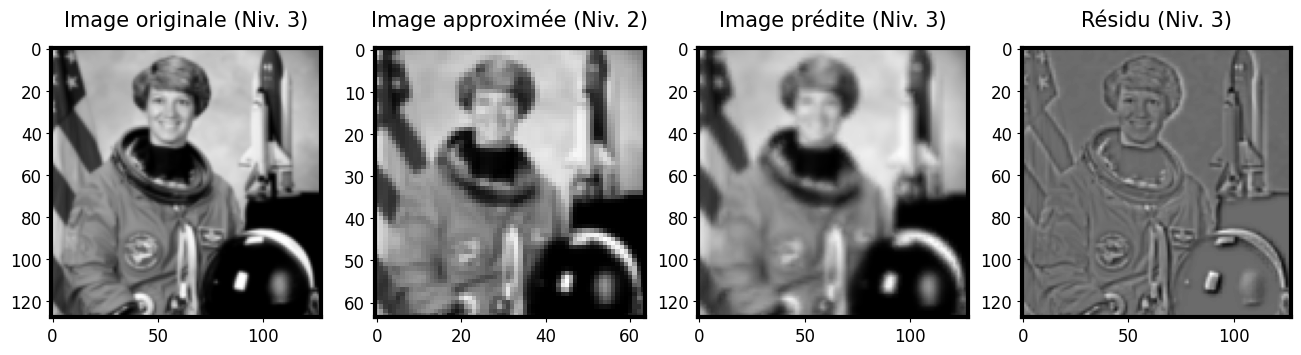

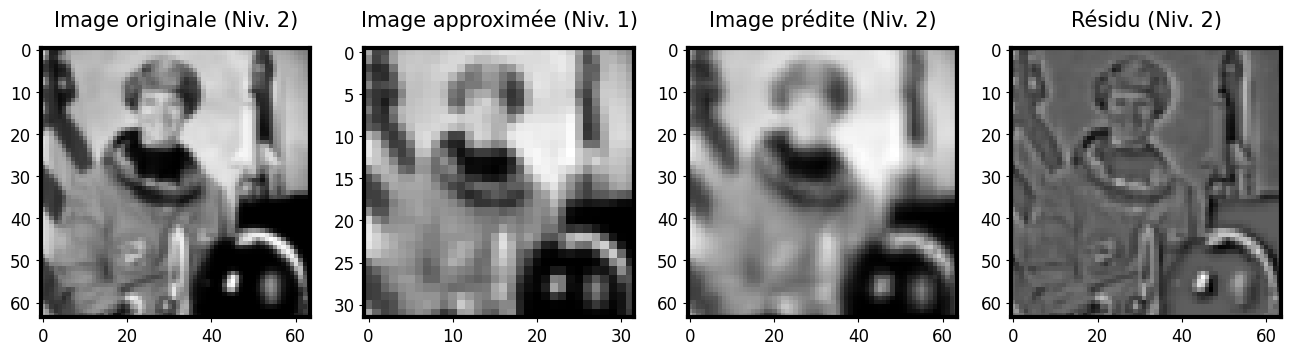

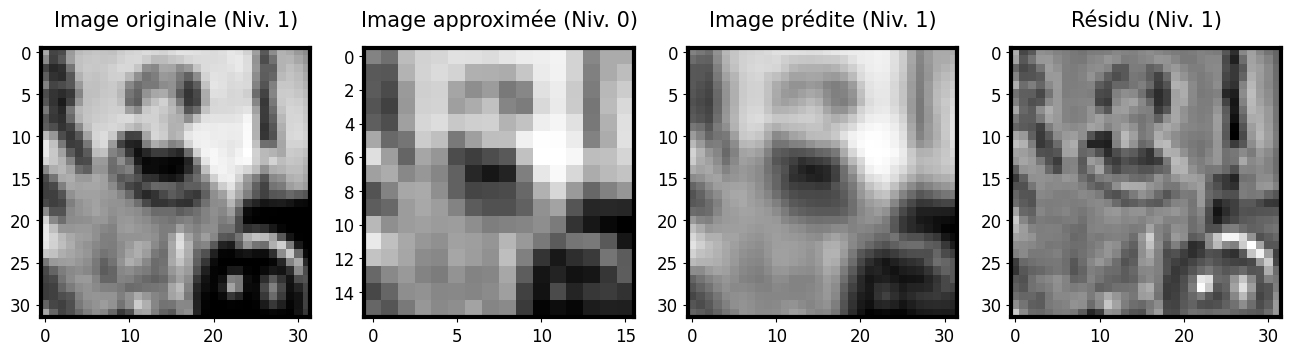

In [8]:
## Exemple de décomposition pyramidale à plusieurs niveaux
nombre_de_niveaux = 5
img_last = image
pyramid_gaussian = list()
pyramid_laplacian = list()
for j in range(nombre_de_niveaux):
    img_approx, img_prediction, img_residu = decomposition_apr(img_last)
    display_pyramid_iteration(img_last, img_approx, img_prediction, img_residu, j)

    # Ajout des approximations et résidus dans chaque pyramide
    pyramid_gaussian.append(img_last)
    pyramid_laplacian.append(img_residu)

    # Modification de la nouvelle image d'entrée
    img_last = img_approx

# Finalement, la dernière approximation est retenue pour chaque décomposition
pyramid_gaussian.append(img_approx)
pyramid_laplacian.append(img_approx)

## Pyramide de Gauss
-	Formée des approximations à chaque niveau.
-	Utilisée pour la synthèse de texture.


In [9]:
def display_pyramid(pyramid):
    nLevels = len(pyramid)

    for i in range(nLevels):
        plt.subplot(1,nLevels,i+1);
        plt.imshow(pyramid[i], aspect='equal')
        plt.axis('off')
        plt.title('Niveau {}'.format(nLevels - i - 1))

    plt.show()

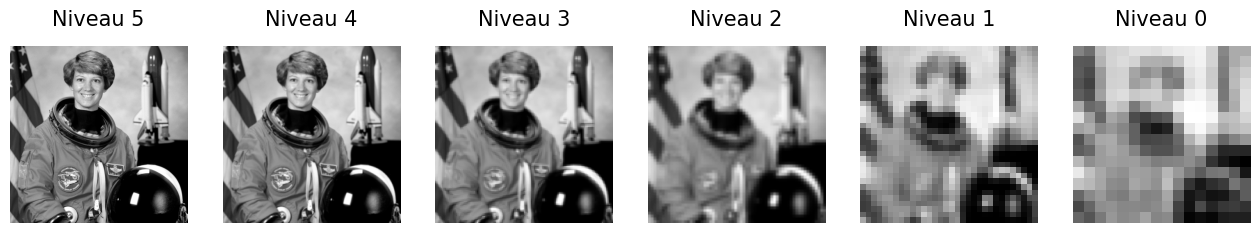

In [10]:
display_pyramid(pyramid_gaussian)

## Pyramide de Laplace

-	Formée des résidus entre l’image originale et l’image filtrée passe-bas à chaque niveau sauf le niveau 0.
-	Au niveau 0, l’image approximée est conservée.
-	Utilisée pour la compression d'image.


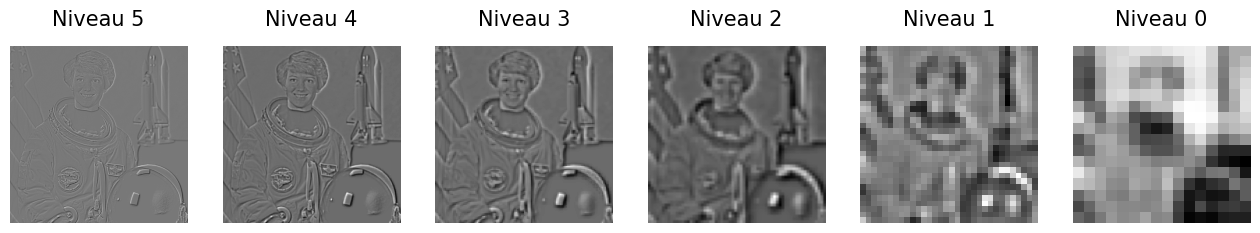

In [11]:
display_pyramid(pyramid_laplacian)

## Exemple de reconstruction pyramidale

In [12]:
def reconstruct_pyramid(pyramid, level):
    nLevels = len(pyramid)
    img_r = pyramid[-1]
    for i in range(1, level):
        img_next = pyramid[nLevels - i - 1]

        # Interpolation bilinéaire
        nx, ny = img_r.shape; nx_next, ny_next = img_next.shape
        x, y = np.meshgrid(np.linspace(0,1,nx), np.linspace(0,1,ny))
        x_next, y_next = np.meshgrid(np.linspace(0,1,nx_next), np.linspace(0,1,ny_next))
        points = np.array([x.ravel(), y.ravel()]).T
        values = img_r.ravel()
        img_r_i = griddata(points, values, (x_next, y_next), method='linear')

        # Ajout du niveau j à la reconstruction
        img_r = img_r_i + img_next

    return img_r

## Reconstruction de la pyramide de Laplace

La pyramide de Laplace peut être utilisée pour compresser une image. L’image originale peut être reconstruite sans pertes. Pour ce faire, l’image approximée du niveau 0 est d’abord sur-échantillonnée pour obtenir la même taille que l’image des résidus au niveau 1. Les résidus et l’image sur-échantillonnée sont ensuite additionnés et le résultat est sur-échantillonné à nouveau pour obtenir la même taille que les résidus du niveau 2. Ces étapes sont répétées jusqu’au niveau de base (taille originale).
Ceci donne un taux de compression de 3 : 512<sup>2</sup> / (265<sup>2</sup> + 128<sup>2</sup> + 64<sup>2</sup> + 32<sup>2</sup> + 16<sup>2</sup>)


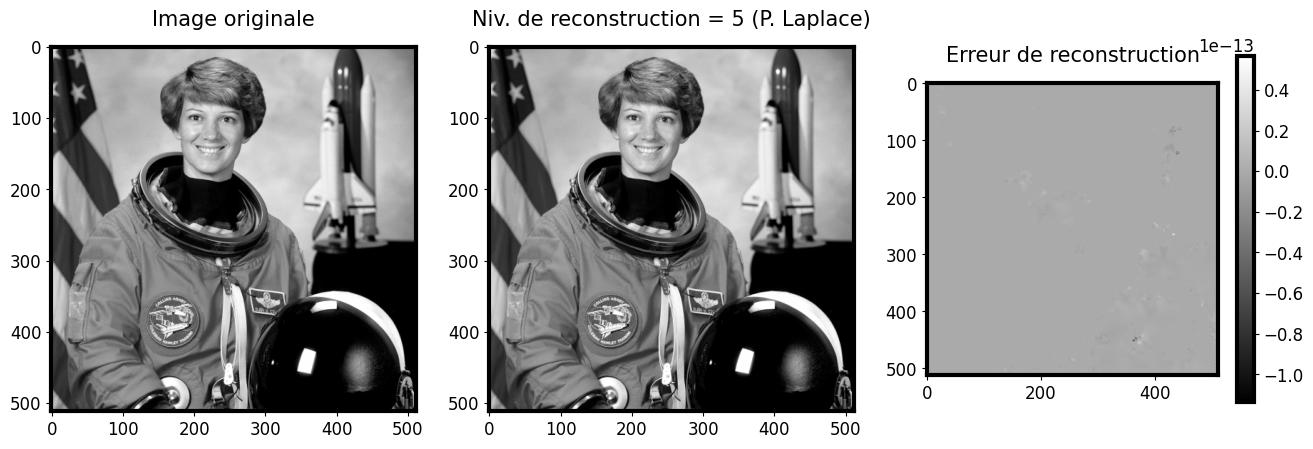

In [13]:
niveau = 6
img_r = reconstruct_pyramid(pyramid_laplacian, niveau)

plt.subplot(131); plt.imshow(image); plt.title('Image originale')
plt.subplot(132); plt.imshow(img_r); plt.title('Niv. de reconstruction = {} (P. Laplace)'.format(niveau-1));
plt.subplot(133); plt.imshow(image - img_r); plt.colorbar(shrink = 0.5); plt.title('Erreur de reconstruction');

plt.show()

## Reconstruction de la pyramide de Gauss

Effectuer la même procédure avec la pyramide de Gauss donne une moins bonne reconstruction. Le contenu à haute fréquence est perdu.

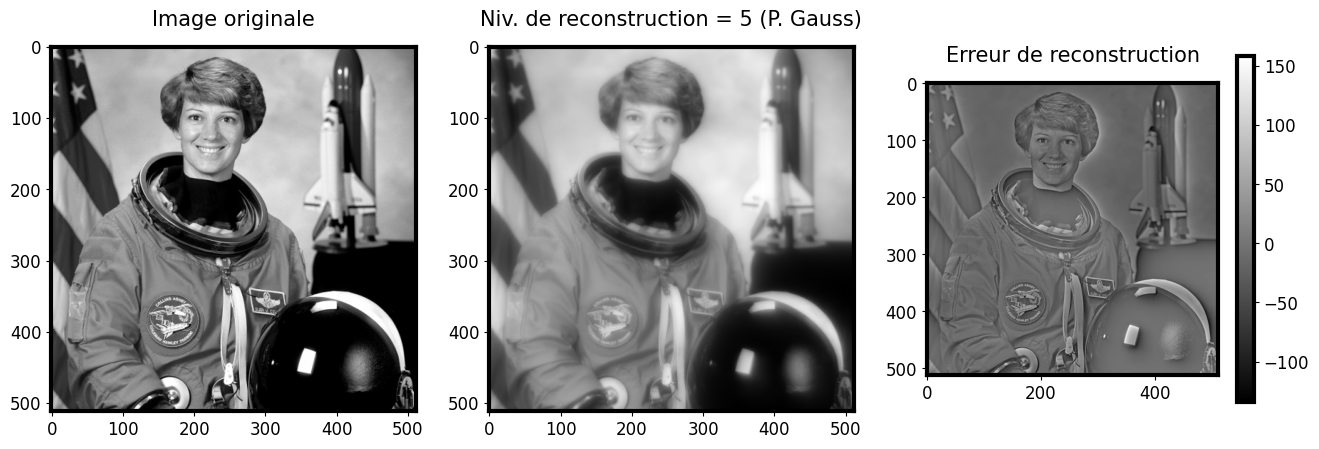

In [15]:
niveau = 6
img_r = reconstruct_pyramid(pyramid_gaussian, niveau)

plt.subplot(131); plt.imshow(image); plt.title('Image originale')
plt.subplot(132); plt.imshow(img_r); plt.title('Niv. de reconstruction = {} (P. Gauss)'.format(niveau-1));
plt.subplot(133); plt.imshow(image - (img_r/np.max(img_r))*255); plt.colorbar(shrink = 0.5); plt.title('Erreur de reconstruction');
plt.show()

# Exemples d'applications

* Compression d'image (Laplace)
* Fusion d'images (Laplace)
* Détection multi-échelles de contours (Gauss)
* Restauration d'image (Laplace)
* Rehaussement
* Champs de vue étendu


## Références
* Gonzalez, R.C. et Woods, R.E. "Digital iamge Processing", 3e édition, _Pearson, Prentice Hall_, (2008), 954p.
* https://en.wikipedia.org/wiki/Pyramid_(image_processing)
* Cours "ELE8812 - Traitement et analyse d'images" de Polytechnique Montréal. ([Lien](https://moodle.polymtl.ca/course/view.php?id=31))
* Notes du cours CSC 320 "Introduction to Visual Computing" @ UToronto. ([Lien](http://www.cs.toronto.edu/~jepson/csc320/notes/pyramids.pdf))